# xG Modelling

xG : Expected Goals

## Setup

In [1]:
import pandas as pd
import numpy as np
import json
import os
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from mplsoccer import VerticalPitch

In [2]:
notebook_directory = os.getcwd()
course_directory = notebook_directory.rsplit("\\Notebooks")[0]
os.chdir(course_directory)

## Data

In [3]:
train_df = pd.DataFrame()

for i in range(13):
    with open(f"data\wyscout\events_England_{i+1}.json") as file:
        data = json.load(file)    
    train_df = pd.concat([train_df, pd.DataFrame(data)])

train_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
43145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
43147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


In [4]:
shots_df = train_df[train_df['eventId'] == 10].copy()
shots_df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212
62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247
91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280
128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289
249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429
...,...,...,...,...,...,...,...,...,...,...,...,...
42945,10,Shot,"[{'id': 401}, {'id': 1212}, {'id': 1802}]",8561,"[{'y': 45, 'x': 72}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,1972.969422,100,251596053
43023,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",41174,"[{'y': 33, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2193.887080,100,251596096
43051,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",7879,"[{'y': 62, 'x': 88}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2377.197700,100,251596357
43055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",145692,"[{'y': 38, 'x': 92}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2381.481625,100,251596359


### Shot Positions
- Need to scale the position of the shots to taking place on a `105*68` pitch, with `x=0` being the goal.
- C is an auxillary variable which will be used to calculate the distance and angle of a shot = distance from a point to the horizontal line through the middle of the pitch.
- Angle Formula [(Sumpter, 2017)](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760):

$$
tan \theta = \frac{7.32x}{x^2 + y^2 - (\frac{7.32}{2})^2}
$$

- Distance = distance on Euclidean plane.

In [5]:
shots_df["X"] = shots_df["positions"].apply(lambda cell: (100-cell[0]["x"]) * 105/100)
shots_df["Y"] = shots_df["positions"].apply(lambda cell: (100-cell[0]["y"]) * 68/100)
shots_df["C"] = shots_df["positions"].apply(lambda cell: abs(100-cell[0]["y"] - 50) * 68/100)

shots_df["Distance"] = np.sqrt(shots_df["X"] ** 2 + shots_df["C"] ** 2)
shots_df["Angle"] = np.where(np.arctan(7.32 * shots_df["X"] / (shots_df["X"] ** 2 + shots_df["C"] ** 2 - (7.32/2)**2)) > 0,  np.arctan(7.32 * shots_df["X"] /(shots_df["X"]**2 + shots_df["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots_df["X"] /(shots_df["X"]**2 + shots_df["C"]**2 - (7.32/2)**2)) + np.pi)
shots_df = shots_df.reset_index()
shots_df

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle
0,46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,40.12,6.12,14.007655,0.467241
1,62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,32.64,1.36,15.808608,0.453557
2,91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,4.20,32.64,1.36,4.414703,1.375115
3,128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,19.95,45.56,11.56,23.057235,0.274666
4,249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,26.25,47.60,13.60,29.563872,0.219665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8446,42945,10,Shot,"[{'id': 401}, {'id': 1212}, {'id': 1802}]",8561,"[{'y': 45, 'x': 72}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,1972.969422,100,251596053,29.40,37.40,3.40,29.595946,0.244517
8447,43023,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",41174,"[{'y': 33, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2193.887080,100,251596096,14.70,45.56,11.56,18.700898,0.309646
8448,43051,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",7879,"[{'y': 62, 'x': 88}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2377.197700,100,251596357,12.60,25.84,8.16,15.011516,0.410444
8449,43055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",145692,"[{'y': 38, 'x': 92}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2381.481625,100,251596359,8.40,42.16,8.16,11.710918,0.461143


In [7]:
shots_df["Goal"] = shots_df["tags"].apply(lambda x: 1 if {"id":101} in x else 0)
shots_df

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,X,Y,C,Distance,Angle,Goal
0,46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,12.60,40.12,6.12,14.007655,0.467241,1
1,62,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'...",26150,"[{'y': 52, 'x': 85}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,179.854785,100,177959247,15.75,32.64,1.36,15.808608,0.453557,0
2,91,10,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Shot,1631,1H,254.745027,100,177959280,4.20,32.64,1.36,4.414703,1.375115,1
3,128,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",7868,"[{'y': 33, 'x': 81}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,425.824035,100,177959289,19.95,45.56,11.56,23.057235,0.274666,0
4,249,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7868,"[{'y': 30, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,815.462015,100,177959429,26.25,47.60,13.60,29.563872,0.219665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8446,42945,10,Shot,"[{'id': 401}, {'id': 1212}, {'id': 1802}]",8561,"[{'y': 45, 'x': 72}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,1972.969422,100,251596053,29.40,37.40,3.40,29.595946,0.244517,0
8447,43023,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",41174,"[{'y': 33, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2193.887080,100,251596096,14.70,45.56,11.56,18.700898,0.309646,1
8448,43051,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",7879,"[{'y': 62, 'x': 88}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2377.197700,100,251596357,12.60,25.84,8.16,15.011516,0.410444,0
8449,43055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",145692,"[{'y': 38, 'x': 92}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2381.481625,100,251596359,8.40,42.16,8.16,11.710918,0.461143,0


#### Plot Shot Location

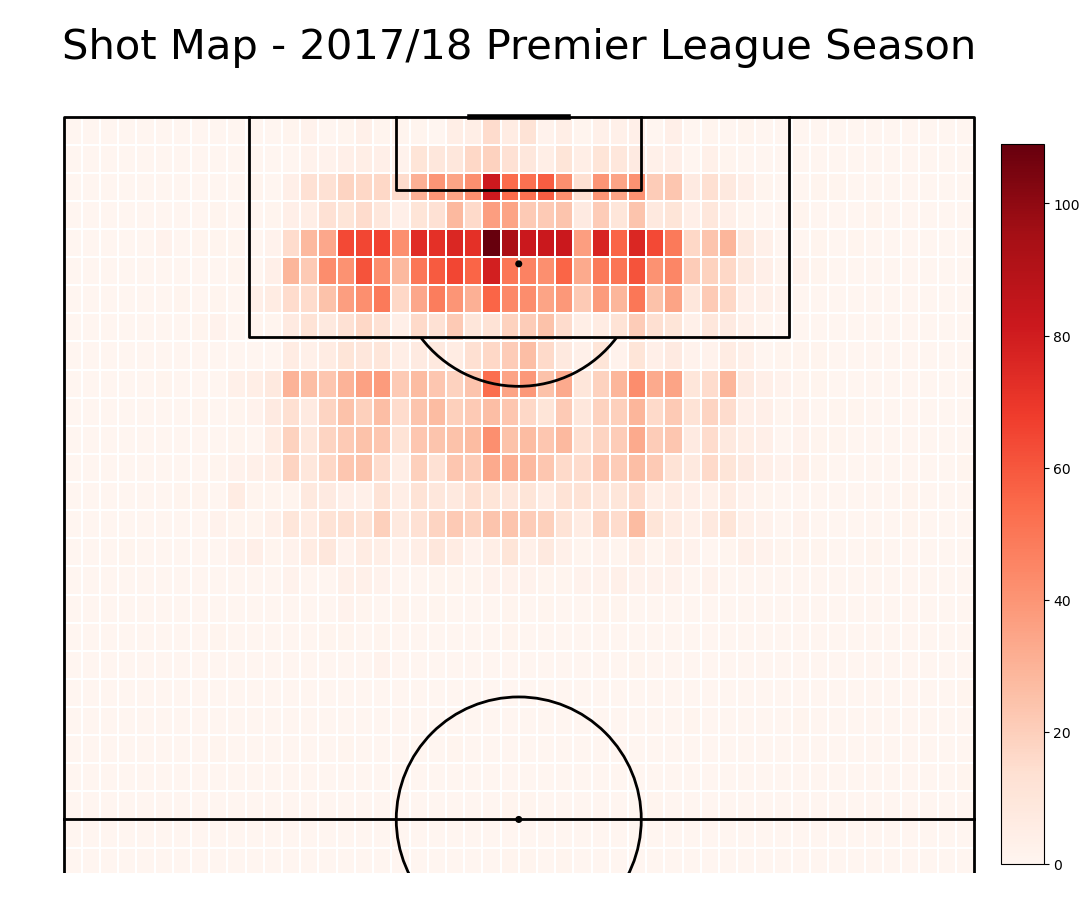

In [27]:
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic_shots = pitch.bin_statistic(105 - shots_df["X"], shots_df["Y"], bins =50)
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap="Reds", edgecolor="white", linewidth=0.01)
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Shot Map - 2017/18 Premier League Season", fontsize=30)
plt.show();

#### Plot Goal Location

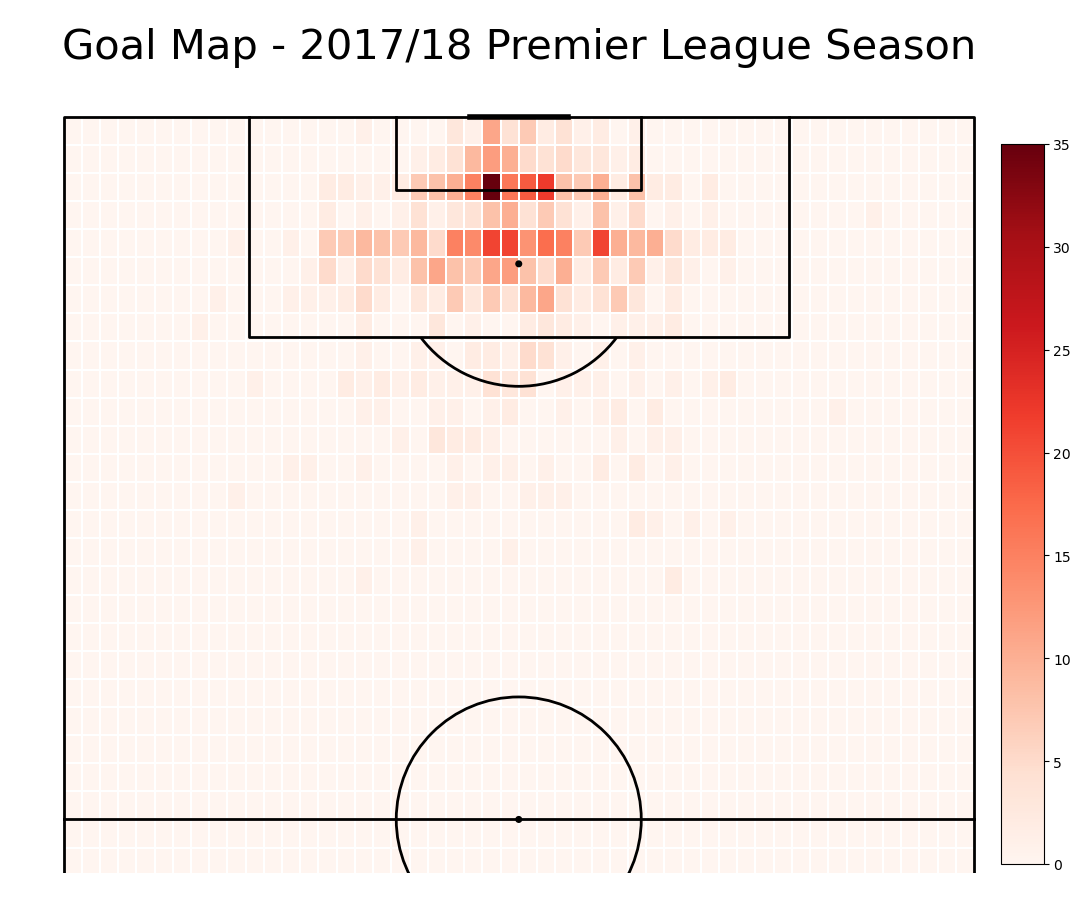

In [28]:
goals = shots_df.loc[shots_df["Goal"] == 1]
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic_goals = pitch.bin_statistic(105 - goals["X"], goals["Y"], bins =50)
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap="Reds", edgecolor="white", linewidth=0.01)
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Goal Map - 2017/18 Premier League Season", fontsize=30)
plt.show();

#### Probability of Scoring based on location

C:\Users\James\AppData\Local\Temp\ipykernel_10580\1308986597.py:4: RuntimeWarning: invalid value encountered in divide
  bin_statistic["statistic"] = bin_statistic_goals["statistic"] / bin_statistic["statistic"]


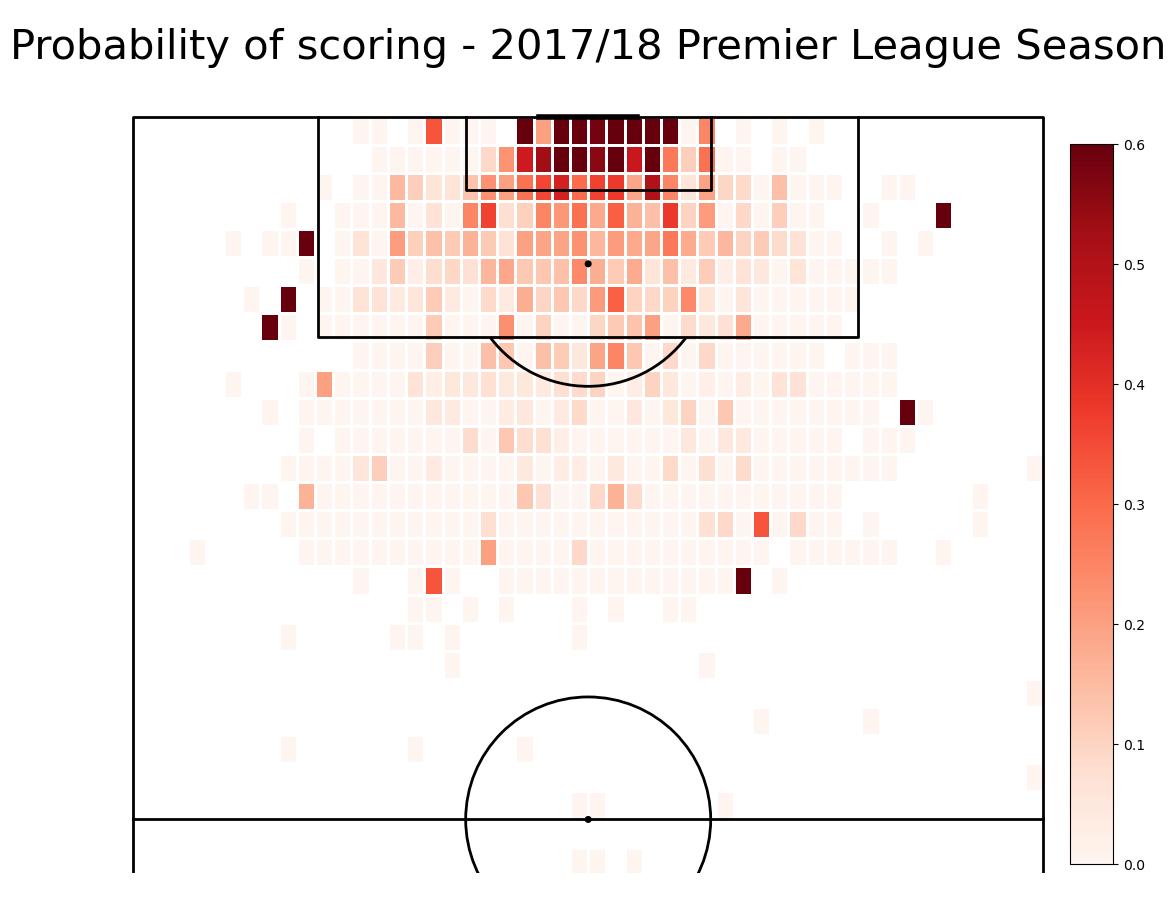

In [36]:
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - shots_df["X"], shots_df["Y"], bins = 50)
bin_statistic["statistic"] = bin_statistic_goals["statistic"] / bin_statistic["statistic"]
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap="Reds", edgecolor="white", vmin=0, vmax=0.6)
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Probability of scoring - 2017/18 Premier League Season" , fontsize = 30)
plt.show();

### xG Model

- Using logistic regression.
- Logistic Formula is:

$$
p(x) = \frac{1}{1+e^{-(x-\mu)/s}}
$$